In [1]:
#pip install Augmentor 

In [2]:
#pip install tensorflow

In [3]:
import os
import shutil
import random

In [4]:
# Paths
raw_data_dir = 'dataset'
split_data_dir = 'split_dataset'

# Split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

In [5]:
# Class names
class_names = ['cardboard', 'glass', 'ied', 'metal', 'paper', 'plastic', 'trash']

In [6]:
# Create directories for split dataset
def create_dirs(base_path):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(os.path.join(base_path, 'train'), exist_ok=True)
    os.makedirs(os.path.join(base_path, 'val'), exist_ok=True)
    os.makedirs(os.path.join(base_path, 'test'), exist_ok=True)
    
    for class_name in class_names:
        os.makedirs(os.path.join(base_path, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(base_path, 'val', class_name), exist_ok=True)
        os.makedirs(os.path.join(base_path, 'test', class_name), exist_ok=True)

In [7]:
# Split images into train, val, test sets
def split_images():
    for class_name in class_names:
        class_dir = os.path.join(raw_data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        random.shuffle(images)
        
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * val_ratio)
        
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]
        
        # Move images to respective directories
        for img in train_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(split_data_dir, 'train', class_name, img))
        for img in val_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(split_data_dir, 'val', class_name, img))
        for img in test_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(split_data_dir, 'test', class_name, img))

# Run the process
create_dirs(split_data_dir)
split_images()

print("Dataset has been split and moved to 'split_dataset'.")

Dataset has been split and moved to 'split_dataset'.


In [8]:
import time # used to measure model training time
exp_start_time = time.time()
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import os
from skimage import io
from PIL import Image
from pathlib import Path
import Augmentor

from sklearn.metrics import confusion_matrix, classification_report, \
        ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import applications
from keras import optimizers, layers, models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, \
    Flatten, Dense, Dropout, Input, Lambda, LeakyReLU, PReLU, Activation

In [9]:
# Define base directory and class names
base_dir = r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset'
class_names = ['cardboard', 'glass', 'ied', 'metal', 'paper', 'plastic', 'trash']

# Function to generate local paths
def generate_paths(base_path, classes):
    paths = {}
    
    for split in ['train', 'val', 'test']:
        for class_name in classes:
            path = os.path.join(base_path, split, class_name)
            paths[path] = os.path.exists(path)  # Check if path exists
    
    return paths

# Generate and print paths
paths = generate_paths(base_dir, class_names)
paths

{'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\cardboard': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\glass': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\ied': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\metal': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\paper': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\plastic': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\train\\trash': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\val\\cardboard': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\val\\glass': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\val\\ied': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\val\\metal': True,
 'C:\\Users\\Ashish\\Assignment1\\I2Net-main\\split_dataset\\val\\paper': True,
 'C:\\Users\\Ashish\

In [11]:
# Training directories
train_dirs = [
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train\cardboard',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train\glass',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train\metal',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train\paper',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train\plastic',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train\trash'
]

# Validation directories
val_dirs = [
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val\cardboard',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val\glass',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val\metal',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val\paper',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val\plastic',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val\trash'
]

# Test directories
test_dirs = [
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test\cardboard',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test\glass',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test\metal',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test\paper',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test\plastic',
    r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test\trash'
]

In [12]:
def count_images_in_dirs(dirs):
    total_images = 0
    for dir_path in dirs:
        total_images += len(os.listdir(dir_path))
    return total_images

## Set general model hyperparameters

In [14]:
# General model hyperparameters
img_height = 224
img_width = 224
num_channels = 3  # 3 for RGB images, 1 for grayscale
batchSize = 128    # Batch size
epochs = 5         # Number of epochs
N = 0              # Number of neurons in the first layer of the top layer
dropout_rate = 0   # Dropout rate (0 means no dropout)
dropout_seed = 200 # Optional seed for dropout

# Convolutional parameters
pool_size = (2, 2)
pool_strides = (2, 2)
kernel_size = (3, 3)
conv2D_strides = (1, 1)

# Target class names
target_names = ['cardboard', 'glass', 'ied', 'metal', 'paper', 'plastic', 'trash']

In [15]:
# Total number of images for training and validation datasets
total_train_images = count_images_in_dirs(train_dirs)
total_val_images = count_images_in_dirs(val_dirs)

In [16]:
# Calculate steps per epoch and validation steps
steps_per_epoch = len(os.listdir(train_paper))//batchSize # terminates an epoch
validation_steps =  len(os.listdir(val_paper))//batchSize

In [17]:
kInitializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=60) # kernel initializer
bInitializer = tf.keras.initializers.TruncatedNormal(mean=0.3, stddev=0.1, seed=60) # bias initializer

import functools
#SS = tf.keras.metrics.SpecificityAtSensitivity()
#recall = tf.keras.metrics.Recall()
#accuracy = tf.keras.metrics.Accuracy()
mse = tf.keras.metrics.MeanSquaredError(name='mean_squared_error', dtype=None)
top1_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=1)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top1_acc.__name__ = 'top1_acc'
top5_acc.__name__ = 'top5_acc'
metrics=['acc','top_k_categorical_accuracy',top1_acc, top5_acc, mse] #, recall, accuracy]

## Define the optimizer for the training

In [19]:
# Stochastic Gradient Descent (SGD) optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.05,
    momentum=0.9,
    clipvalue=1.0,
    nesterov=True
)

## Activation function

In [21]:
activation_function = Activation('relu')

## Define functions for data standardization

In [23]:
# Create the image data generator to standardize the images
datagen = ImageDataGenerator(
    rescale=1./255,                  # Scale pixel values to [0, 1]
    featurewise_center=True,         # Center images by mean pixel value
    featurewise_std_normalization=True, # Standardize images by removing mean and scaling to unit variance
)

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path, img_height, img_width, img_ext='jpg'):
    from pathlib import Path
    from PIL import Image
    import numpy as np

    def read_pil_image(img_path, img_height, img_width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((img_width, img_height)))

    return np.array([read_pil_image(str(p), img_height, img_width) for p in Path(dataset_path).rglob("*."+img_ext)])

### Perform standardization and normalization of non-augmented dataset

In [25]:
# Load images for training and validation
train_images = load_and_preprocess_images(train_dirs[0], img_height, img_width)
val_images = load_and_preprocess_images(val_dirs[0], img_height, img_width)

# Fit the data generator to the training dataset
datagen.fit(train_images)

# Example of how to use the data generator
train_generator = datagen.flow_from_directory(
    directory=r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\train',
    target_size=(img_height, img_width),
    batch_size=batchSize,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    directory=r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\val',
    target_size=(img_height, img_width),
    batch_size=batchSize,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    directory=r'C:\Users\Ashish\Assignment1\I2Net-main\split_dataset\test',
    target_size=(img_height, img_width),
    batch_size=batchSize,
    class_mode='categorical'
)

Found 1882 images belonging to 7 classes.
Found 401 images belonging to 7 classes.
Found 410 images belonging to 7 classes.


## Function to compute the classification performance

In [27]:
def classification_performance(y_test, y_pred):
    #tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_true = y_test, y_pred = y_pred, normalize=True, sample_weight=None),2)
    precision = round(precision_score(y_true = y_test, y_pred = y_pred, average='weighted'),2)
    recall = round(recall_score(y_true = y_test, y_pred = y_pred, average='weighted'),2)
    f1_score = round(2*precision*recall/(precision + recall),2)    
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)

    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         })
    return result

In [43]:
def classification_performance(y_test, y_pred, y_prob):
    accuracy = round(accuracy_score(y_true=y_test, y_pred=y_pred), 2)
    precision = round(precision_score(y_true=y_test, y_pred=y_pred, average='weighted'), 2)
    recall = round(recall_score(y_true=y_test, y_pred=y_pred, average='weighted'), 2)
    f1_score = round(2 * precision * recall / (precision + recall), 2)
    
    try:
        auc_roc = round(roc_auc_score(y_true=y_test, y_score=y_prob, multi_class='ovr'), 2)
    except ValueError as e:
        auc_roc = str(e)
    
    result = pd.DataFrame({
        'Accuracy': [accuracy],
        'Precision (or PPV)': [precision],
        'Recall (sensitivity or TPR)': [recall],
        'F1 Score': [f1_score],
        'AUC-ROC': [auc_roc],
    })
    return result

## Define a function for the top layer in transfer learning

In [29]:
def new_top_layers(input_model):
    output_model = Sequential()
    output_model.add(input_model)
    output_model.add(Flatten())
    output_model.add(Dense(N,  # number of neurons in first layer of top layer
        use_bias=True,
        kernel_initializer=kInitializer,
        bias_initializer=bInitializer,
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None))
    output_model.add(activation_function)
    output_model.add(layers.Dropout(rate=dropout_rate, seed=dropout_seed)) # add dropout to mimize overfitting
    
    output_model.add(Dense(7, # layer has only 7 neurons for seven classes
        use_bias=True,
        kernel_initializer=kInitializer,
        bias_initializer=bInitializer,
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None, 
        activation='softmax')) 
    return output_model

## TL 1: Transfer Learning with MobileNetV2

In [31]:
# Create the pretrained model as the base model
from keras.applications.mobilenet_v2 import MobileNetV2 # import the pre-trained model

base_model_MblNetV2 = MobileNetV2(input_shape=(img_height, img_width, 3), 
                include_top=False, # ideal for feature extraction
                weights='imagenet' )

base_model_MblNetV2.trainable = False # Prevent the weights of the base model from being updated before compiling & training the model

In [32]:
# Find number of model parameters
base_model_MblNetV2.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
# Add extra layers to the pre-trained base model by function call
def new_top_layers(base_model, num_classes=7, dropout_rate=0.5, dropout_seed=200):
    if not base_model:
        raise ValueError("Base model is not defined.")
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate, seed=dropout_seed)(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [34]:
# Load the base model with MobileNetV2
base_model_MblNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

# Add custom top layers
MblNetV2_model = new_top_layers(base_model_MblNetV2)

# Print model summary
MblNetV2_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
# Compile the model
MblNetV2_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [36]:
#Fit the model to the dataset
MNv2_st = time.time()
history = MblNetV2_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    #workers = 4,
    validation_data = val_generator,
    validation_steps = validation_steps)
MNv2_et = time.time()
MNv2_training_time = MNv2_et - MNv2_st
print('Model training time in seconds: ', MNv2_training_time)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - acc: 0.1963 - loss: 3.7632 - mean_squared_error: 0.1590 - top1_acc: 0.1963 - top5_acc: 0.7520 - top_k_categorical_accuracy: 0.7520 - val_acc: 0.2618 - val_loss: 5.1022 - val_mean_squared_error: 0.1574 - val_top1_acc: 0.2618 - val_top5_acc: 0.5985 - val_top_k_categorical_accuracy: 0.5985
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - acc: 0.2258 - loss: 5.9693 - mean_squared_error: 0.1738 - top1_acc: 0.2258 - top5_acc: 0.5920 - top_k_categorical_accuracy: 0.5920 - val_acc: 0.3466 - val_loss: 1.6616 - val_mean_squared_error: 0.1055 - val_top1_acc: 0.3466 - val_top5_acc: 0.7980 - val_top_k_categorical_accuracy: 0.7980
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - acc: 0.3529 - loss: 1.8340 - mean_squared_error: 0.1069 - top1_acc: 0.3529 - top5_acc: 0.7708 - top_k_categorical_accuracy: 0.7708 - val_acc: 0.5461 - val_loss: 1.6392 - val_mean_squared_error: 0.1069 - val_top1_acc: 0.5461 - val_top5_acc: 0.9676 - val_top_k_categorical_accura

## Evaluate results

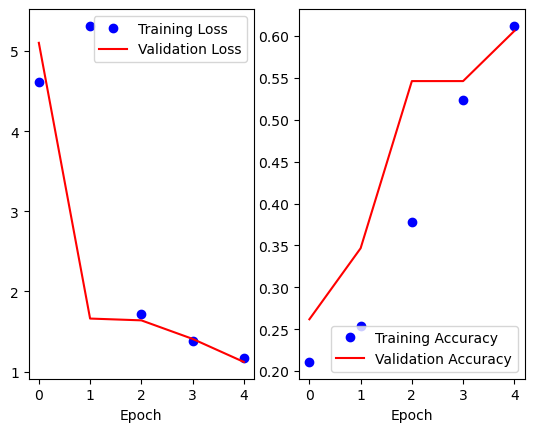

In [38]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(history.history['loss'], 'bo',label='Training Loss')
ax1.plot(history.history['val_loss'], '-r', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
#ax1.set_ylabel('Loss')
##plt.savefig('LossVal_loss')

ax2.plot(history.history['acc'], 'bo',label='Training Accuracy')
ax2.plot(history.history['val_acc'], '-r', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
#ax2.set_ylabel('Accuracy')
plt.show()

In [39]:
#Find the maximum accuracy and its corresponding losses

valAccuracy = np.array(history.history['val_acc'])
trainAccuracy = np.array(history.history['acc'])
valLoss = np.array(history.history['val_loss'])
trainLoss = np.array(history.history['loss'])

epoch0 = np.where(valAccuracy==max(valAccuracy))
print(epoch0)
max_val_acc = valAccuracy[epoch0]
cor_train_acc = trainAccuracy[epoch0] # Train accuracy corresponding to the max val accuracy
cor_val_loss = valLoss[epoch0]
cor_train_loss = trainLoss[epoch0]

print('epoch for max val acc: ', epoch0)
print('max val acc; ', max_val_acc)
print('cor_val_loss: ', cor_val_loss)
print('cor_train_loss: ', cor_train_loss)
print('cor_train_acc: ', cor_train_acc)


(array([4], dtype=int64),)
epoch for max val acc:  (array([4], dtype=int64),)
max val acc;  [0.60598505]
cor_val_loss:  [1.12051904]
cor_train_loss:  [1.16346943]
cor_train_acc:  [0.61197919]


In [40]:
#Evaluate model performance on test dataset
results = MblNetV2_model.evaluate(test_generator)
for i in range(len(MblNetV2_model.metrics_names)):
    print(MblNetV2_model.metrics_names[i], " : ", results[i])

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - acc: 0.6637 - loss: 1.1156 - mean_squared_error: 0.0748 - top1_acc: 0.6637 - top5_acc: 0.9366 - top_k_categorical_accuracy: 0.9366
loss  :  1.10191810131073
compile_metrics  :  0.6658536791801453


## Compute performance metrics, e.g. recall and precision

In [49]:
Y_pred = MblNetV2_model.predict(test_generator, len(os.listdir(test_paper)) // batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
res = classification_performance(test_generator.classes, y_pred, Y_pred)
print(res['Recall (senitivity or TPR)'])
print(res['Precision (or PPV)'])
print(res['f1 score'])
print(res['Accuracy'])
print(res['AUC_ROC'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


KeyError: 'Recall (senitivity or TPR)'

In [51]:
### Use model for prediction and compute the confusion matrix (CM)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Confusion Matrix
[[11 13  0 15 13  9  0]
 [21 12  0 10 24  9  0]
 [ 5  7  0  5  7  2  0]
 [11 20  0 11 13  7  0]
 [22 26  0 12 22  8  0]
 [14 14  0 15 10 20  0]
 [ 3  7  0  7  3  2  0]]
Classification Report
              precision    recall  f1-score   support

   cardboard       0.13      0.18      0.15        61
       glass       0.12      0.16      0.14        76
         ied       0.00      0.00      0.00        26
       metal       0.15      0.18      0.16        62
       paper       0.24      0.24      0.24        90
     plastic       0.35      0.27      0.31        73
       trash       0.00      0.00      0.00        22

    accuracy                           0.19       410
   macro avg       0.14      0.15      0.14       410
weighted avg       0.18      0.19      0.18       410



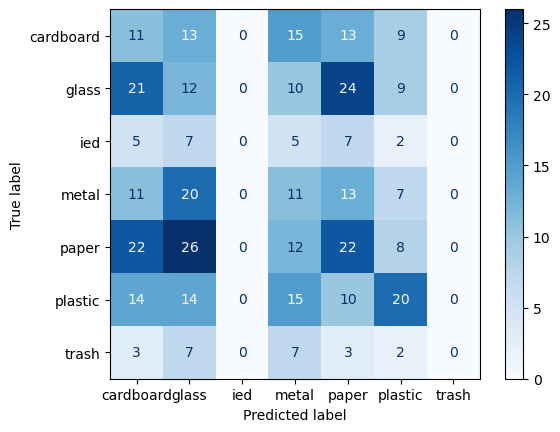

In [53]:
Y_pred = MblNetV2_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm)

print('Classification Report')
target_names = target_names
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## TL 2: Transfer Learning with DenseNet121

In [56]:
# Create the pretrained model as the base model
base_model_DN121 = tf.keras.applications.DenseNet121(input_shape=(img_height, img_width, 3), 
                include_top=False, # ideal for feature extraction
                weights='imagenet' )

base_model_DN121.trainable = False # Prevent the weights of the base model from being updated before compiling & training the model


In [58]:
base_model_DN121.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [60]:
# Add extra layers to the pre-trained base model by function call
DN121_model = new_top_layers(base_model_DN121)

In [62]:
# Find the number of parameters
DN121_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,094,279 (30.88 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [64]:
# Compile the model
DN121_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [68]:
#Fit the model to the dataset
DN121_st = time.time() # start the clock
history = DN121_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    #workers = 4,
    validation_data = val_generator,
    validation_steps =  validation_steps)

DN121_et = time.time()
DN121_training_time = (DN121_et - DN121_st)/60
print('Model training time in minutes is: ', DN121_training_time)

Epoch 1/5


ValueError: Unknown variable: <KerasVariable shape=(1024, 1024), dtype=float32, path=dense_2/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

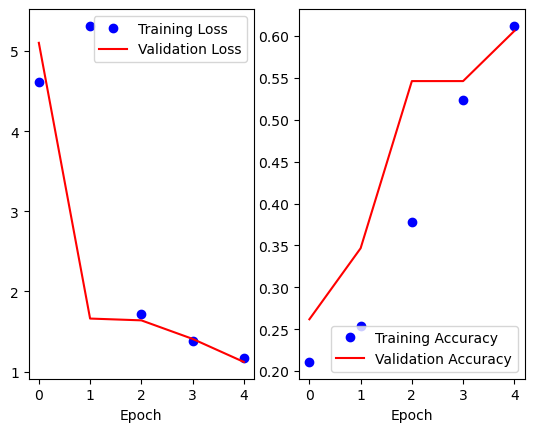

In [70]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(history.history['loss'], 'bo',label='Training Loss')
ax1.plot(history.history['val_loss'], '-r', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
#ax1.set_ylabel('Loss')
plt.savefig('LossVal_loss')

ax2.plot(history.history['acc'], 'bo',label='Training Accuracy')
ax2.plot(history.history['val_acc'], '-r', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
#ax2.set_ylabel('Accuracy')
plt.show()
#plt.savefig('AccVal_acc')

In [72]:
#Evaluate model performance on test dataset
results = MblNetV2_model.evaluate(test_generator)
for i in range(len(MblNetV2_model.metrics_names)):
    print(MblNetV2_model.metrics_names[i], " : ", results[i])

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - acc: 0.6804 - loss: 1.0774 - mean_squared_error: 0.0722 - top1_acc: 0.6804 - top5_acc: 0.9429 - top_k_categorical_accuracy: 0.9429
loss  :  1.10191810131073
compile_metrics  :  0.6658536791801453


In [74]:
Y_pred = MblNetV2_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
res = classification_performance(test_generator.classes, y_pred)
print(res.recall)
print(res.precision)
print(res.f1_score)
print(res.accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


TypeError: classification_performance() missing 1 required positional argument: 'y_prob'

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Confusion Matrix
[[ 9 16  0 12 13 11  0]
 [13 19  0 14 22  8  0]
 [ 7  8  0  5  3  3  0]
 [13 15  0 14 11  9  0]
 [23 16  0 16 21 14  0]
 [18 19  0 13 14  9  0]
 [ 4  6  0  1  8  3  0]]
Classification Report
              precision    recall  f1-score   support

   cardboard       0.10      0.15      0.12        61
       glass       0.19      0.25      0.22        76
         ied       0.00      0.00      0.00        26
       metal       0.19      0.23      0.20        62
       paper       0.23      0.23      0.23        90
     plastic       0.16      0.12      0.14        73
       trash       0.00      0.00      0.00        22

    accuracy                           0.18       410
   macro avg       0.12      0.14      0.13       410
weighted avg       0.16      0.18      0.16       410



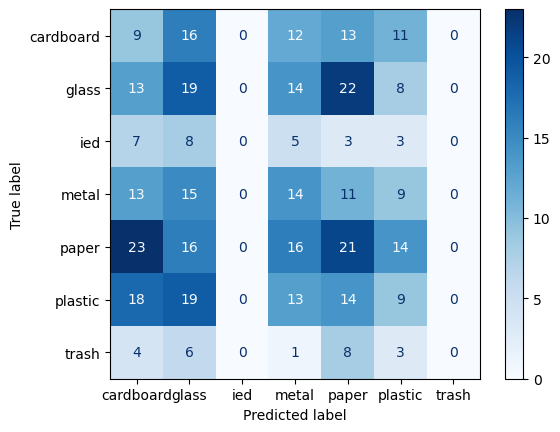

In [76]:
Y_pred = MblNetV2_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm)

print('Classification Report')
target_names = target_names
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()
